In [1]:
import utils.datasets

# import util.datasets
import tensorflow as tf
import numpy as np

import os

2022-10-13 14:45:11.008327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 14:45:11.136464: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-13 14:45:11.143707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 14:45:11.143722: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [202]:
train, test = utils.datasets.pascal_voc_detection(os.path.normpath("/home/FYP/wang1570/datasets/pascal-voc-2012/VOCdevkit/VOC2012")).load()

loaded using cache file


In [192]:
import matplotlib.pyplot as plt

In [203]:
imgs = train[0]
img = imgs[0]

In [208]:
img[:, 50:100] = 100

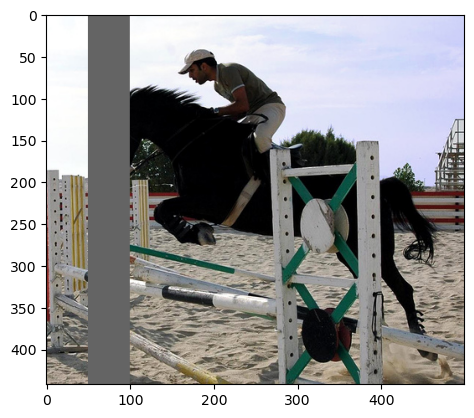

In [209]:
plt.imshow(img)

In [64]:
from easydict import EasyDict as edict
import numpy as np

# pascal voc 2012
pascal_voc_2012 = edict()
pascal_voc_2012.classes = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
                    'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                    'sheep', 'sofa', 'train', 'tvmonitor']
pascal_voc_2012.pixel_means = np.array([[[102.9801, 115.9465, 122.7717]]])
pascal_voc_2012.max_size = 1000
pascal_voc_2012.min_size = 600

# vgg16
vgg16 = edict()
vgg16.feature_stride = 16 # when input size = 224, output = 14, strive = 224/14

# anchor
anchors = edict()
anchors.ratios = np.array([0.5, 1, 2])
anchors.scales = np.array([8, 16, 32])

cfg = edict()
cfg.db = pascal_voc_2012
cfg.backbone = vgg16
cfg.anchors = anchors

In [114]:
import numpy as np
import tensorflow as tf

def generate_anchor_shifts():
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, 15, 15) window.
    """
    """
    [
      ...,
      [x_low_shift, y_low_shit, x_high_shift, y_high_shift],
      ...,
    ]
    """
    feature_stride = cfg.backbone.feature_stride
    ratios = cfg.anchors.ratios
    scales = cfg.anchors.scales
    base_anchor = np.array([1, 1, feature_stride, feature_stride]) - 1
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales)
                         for i in range(ratio_anchors.shape[0])]) 
    return anchors


def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """

    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr


def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """

    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    return anchors


def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors


def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

anchor_shifts = generate_anchor_shifts()

def generate_anchor_centres(h, w):
  """
  to get cor = 
  [
    ...,
    [x_centre, y_centre, x_centre, y_centre],
    ...,
  ]
  """
  xs = tf.range(h) * cfg.backbone.feature_stride
  ys = tf.range(w) * cfg.backbone.feature_stride
  xs, ys = tf.meshgrid(xs, ys)
  xs = tf.reshape(xs, (-1, ))
  ys = tf.reshape(ys, (-1, ))
  # get combination of each position
  cor = tf.stack([ys, xs])
  # double to match the anchor shift
  cor = tf.concat([cor, cor], axis = 0)
  cor = tf.transpose(cor)
  cor = tf.expand_dims(cor, axis = 1)

  return cor

def generate_anchors(h, w):
  """
  to get cor = 
  [
    ...,
    [x_centre + x_low_shift, y_centre + y_low_shift, x_centre + x_high_shift, y_centre + y_high_shift],
    ...,
  ]
  """
  cor = generate_anchor_centres(h, w)
  cor = tf.add(cor, anchor_shifts)
  cor = tf.reshape(cor, (-1, 4))
  return cor
  

In [115]:
generate_anchors(1, 2)

<tf.Tensor: shape=(18, 4), dtype=int32, numpy=
array([[ -84,  -40,   99,   55],
       [-176,  -88,  191,  103],
       [-360, -184,  375,  199],
       [ -56,  -56,   71,   71],
       [-120, -120,  135,  135],
       [-248, -248,  263,  263],
       [ -36,  -80,   51,   95],
       [ -80, -168,   95,  183],
       [-168, -344,  183,  359],
       [ -68,  -40,  115,   55],
       [-160,  -88,  207,  103],
       [-344, -184,  391,  199],
       [ -40,  -56,   87,   71],
       [-104, -120,  151,  135],
       [-232, -248,  279,  263],
       [ -20,  -80,   67,   95],
       [ -64, -168,  111,  183],
       [-152, -344,  199,  359]], dtype=int32)>

In [117]:
arg = [False, tf.keras.initializers.RandomNormal(stddev=0.01)]
a = tf.keras.layers.Conv2D(10, (3, 3),'same', *arg)

ValueError: The `strides` argument must be a tuple of 2 integers. Received: same

In [118]:
a = tf.range(50)

In [135]:
a = tf.reshape(a, (5, 5, 2))

In [168]:
a = tf.random.uniform((5, 5, 2))

In [174]:
b = tf.reshape(a, (-1, 2))
b = tf.cast(b, dtype = 'float')
b

<tf.Tensor: shape=(25, 2), dtype=float32, numpy=
array([[0.717497  , 0.04890013],
       [0.16746831, 0.626809  ],
       [0.40473008, 0.82172346],
       [0.60019577, 0.7794467 ],
       [0.17423964, 0.98111546],
       [0.5856674 , 0.45322704],
       [0.3817389 , 0.12977862],
       [0.9745786 , 0.30084693],
       [0.454031  , 0.7016636 ],
       [0.03043282, 0.0470978 ],
       [0.08154368, 0.60092425],
       [0.205073  , 0.49768186],
       [0.6479666 , 0.09068   ],
       [0.28856456, 0.00207877],
       [0.7204088 , 0.03900468],
       [0.80403876, 0.6167313 ],
       [0.81875885, 0.8785411 ],
       [0.96998656, 0.39076102],
       [0.597306  , 0.37829578],
       [0.14391887, 0.1101414 ],
       [0.12568688, 0.9189284 ],
       [0.3242582 , 0.74013686],
       [0.06414032, 0.52793026],
       [0.9763073 , 0.15707576],
       [0.6634358 , 0.40364373]], dtype=float32)>

In [175]:
sfx = tf.keras.layers.Softmax()

In [180]:
c = sfx(b)

In [160]:
b = sfx(b)

In [161]:
b

<tf.Tensor: shape=(25, 2), dtype=float32, numpy=
array([[0.33009166, 0.6699084 ],
       [0.3859114 , 0.61408854],
       [0.54872304, 0.45127696],
       [0.6602586 , 0.33974147],
       [0.39178005, 0.6082199 ],
       [0.3494278 , 0.6505722 ],
       [0.5778642 , 0.42213577],
       [0.7015324 , 0.2984676 ],
       [0.4707093 , 0.5292906 ],
       [0.4887995 , 0.5112004 ],
       [0.48308527, 0.5169147 ],
       [0.4728128 , 0.5271871 ],
       [0.62336606, 0.3766338 ],
       [0.532678  , 0.46732196],
       [0.6687524 , 0.3312477 ],
       [0.399322  , 0.6006779 ],
       [0.3421771 , 0.65782285],
       [0.6487055 , 0.35129446],
       [0.29582977, 0.7041702 ],
       [0.6982505 , 0.30174953],
       [0.599907  , 0.40009302],
       [0.6307677 , 0.3692323 ],
       [0.46797407, 0.53202593],
       [0.42641565, 0.5735843 ],
       [0.6259441 , 0.37405592]], dtype=float32)>